# Navigating by Falling Stars: Monetary Policy with Fiscally Driven Natural Rates
## Transition to the new steady state in under different assumptions of monetary behavior

This notebook does the following:
1. It computes the transition to the new steady state under different monetary policy rules. It considers the following cases:
   - Taylor rule responds to the output gap
   - Orphanides-Williams rule
   - No interest rate smoothing
   - No reaction by the monetary authority
3. It saves the impulse response functions for these cases in `irfs/irf_with_OG.json`, `irfs/irf_orphanides.json`, `irfs/irf_no_smoothing.json`, and `irfs/irf_no_reaction.json`.
4. It produces Figure 6 in the paper.
7. It produces the following figures that appear in the Appendix:
   - Figure 14: no monetary policy adjustment
   - Figure 15: no interest rate smoothing

### Requirements
The code requires that the files `irfs/irf_baseline.json`, `ss/ss_hank_ini.json` and `ss/ss_hank_end.json` exist. It imports various versions of the model from the file `model.py` and various functions from `utils.py`. The code is othwerwise self-contained.

In [1]:
# Standard imports
import json
import os
import numpy as np

# Other imports
import sequence_jacobian as sj

from model import hank_og, hank_ow, hank_lb, hank_ns
from utils import rebase_irf, plot_irfs, plot_residuals, is_residual

## Taylor rule that responds to the Output Gap

In [2]:
print("\n")
print("=" *80)
print(f"The {hank_og.name} model")
print("=" *80)
print(*hank_og.blocks, sep='\n')

# Print out inputs and outputs of the HANK model
print(f"The {hank_og.name} has inputs{hank_og.inputs}")
print("-" * 80)
print(f"The {hank_og.name} has outputs {hank_og.outputs}")




The Two-Asset HANK with a Taylor rule that responds to the OG model
<SolvedBlock 'labor_to_investment_combined_solved'>
<SolvedBlock 'pricing_solved'>
<SolvedBlock 'taylor_smooth_og'>
<SolvedBlock 'q_lb'>
<SimpleBlock 'rpost_lb'>
<SimpleBlock 'wage'>
<SimpleBlock 'dividend'>
<SolvedBlock 'G_rule'>
<SimpleBlock 'outcomes'>
<SolvedBlock 'arbitrage_solved'>
<SimpleBlock 'finance'>
<HetBlock 'hh' with hetinput 'make_grids_marginal_cost_grid' and with hetoutput `adjustment_costs'>
<SimpleBlock 'union'>
<SimpleBlock 'mkt_clearing'>
The Two-Asset HANK with a Taylor rule that responds to the OG has inputs['beta', 'eis', 'rb', 'chi0', 'chi1', 'chi2', 'chi3', 'tax', 'w', 'Transfer', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'Y', 'Z', 'alpha', 'ra_e', 'delta', 'epsI', 'kappap', 'mup', 'pi_ss', 'tau_d', 'Gbar', 'Bgbar', 'phi_G', 'kappaw', 'muw', 'vphi', 'frisch', 'rbar', 'phi', 'pibar', 'rho_i', 'phi_og', 'delta_lb']
-----------------------------------------------------

In [3]:
additional_parameters = {
    'phi_og': 0.1,  # Orphanides and Wieland (1998) 
}

data = json.load(open(os.path.join("ss", "ss_hank_ini.json")))
data_with_additional = {**data, **additional_parameters}
ss_hank_ini = hank_og.steady_state(data_with_additional, dissolve=[
    'taylor_smooth_og',
    'G_rule',
])

print("-" * 80)
print("Initial SS")
print(f"Asset market clearing: {ss_hank_ini['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_ini['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_ini['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_ini.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

data = json.load(open(os.path.join("ss", "ss_hank_end.json")))
data_with_additional = {**data, **additional_parameters}
ss_hank_end = hank_og.steady_state(data_with_additional, dissolve=[
    'taylor_smooth_og',
    'G_rule',
])

print("-" * 80)
print("Final SS")
print(f"Asset market clearing: {ss_hank_end['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_end['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_end['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_end.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

--------------------------------------------------------------------------------
Initial SS
Asset market clearing:  2.36e-06
Bond market clearing: -2.24e-08
Goods market clearing (untargeted):  6.48e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
i_res: 0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: -0.000000
equity_res: 0.000000
wnkpc_res: 0.000000
asset_mkt: 0.000002
bond_mkt: -0.000000
goods_mkt: 0.000000
--------------------------------------------------------------------------------
Final SS
Asset market clearing: -5.32e-08
Bond market clearing:  4.97e-08
Goods market clearing (untargeted):  4.52e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: -0.000000
nkpc_res: 0.000000
i_res: -0.000000
q_lb_res: -0.000000
rpost_res: 0.000000
B_res: 0.000000
equity_res: -0.000000
wnkpc_res: -0.0

In [4]:
T = 300

drbar = (ss_hank_end['rbar'] - ss_hank_ini['rbar']) * np.ones(T)
dGbar = (ss_hank_end['Gbar'] - ss_hank_ini['Gbar']) * np.ones(T)
dBgbar = (ss_hank_end['Bgbar'] - ss_hank_ini['Bgbar']) * np.ones(T)

shocks = {'Gbar': dGbar, 'Bgbar': dBgbar, 'rbar': drbar}

shocks_rebased = rebase_irf(ss_hank_ini, ss_hank_end, shocks)
exogenous = shocks_rebased

unknowns = ['Y', 'w', 'ra_e', 'rb']
targets = ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']

hank_og.solve_impulse_nonlinear_options['maxit'] = 100
hank_og.solve_impulse_nonlinear_options['tol'] = 1e-9

irf_hank_og_r =  hank_og.solve_impulse_nonlinear(ss_hank_end, unknowns, targets, exogenous, ss_initial=ss_hank_ini)

Solving Two-Asset HANK with a Taylor rule that responds to the OG for ['Y', 'w', 'ra_e', 'rb'] to hit ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 0.00E+00
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 1.34E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 1.03E-08
On iteration 3
   max error for inv_res is 7.13E-09
   max error for val_res is 4.17E-11
On iteration 4
   max error for inv_res is 3.57E-11
   max error for val_res is 2.23E-13
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 1.71E-04
On iteration 1
   max error for nkpc_res is 4.60E-07
On iteration 2
   max error for nkpc_res is 1.95E-09
On iteration 3
   max error for nkpc_res is 7.42E-12
Solving taylor_smooth_og_inner for ['i'] to hit

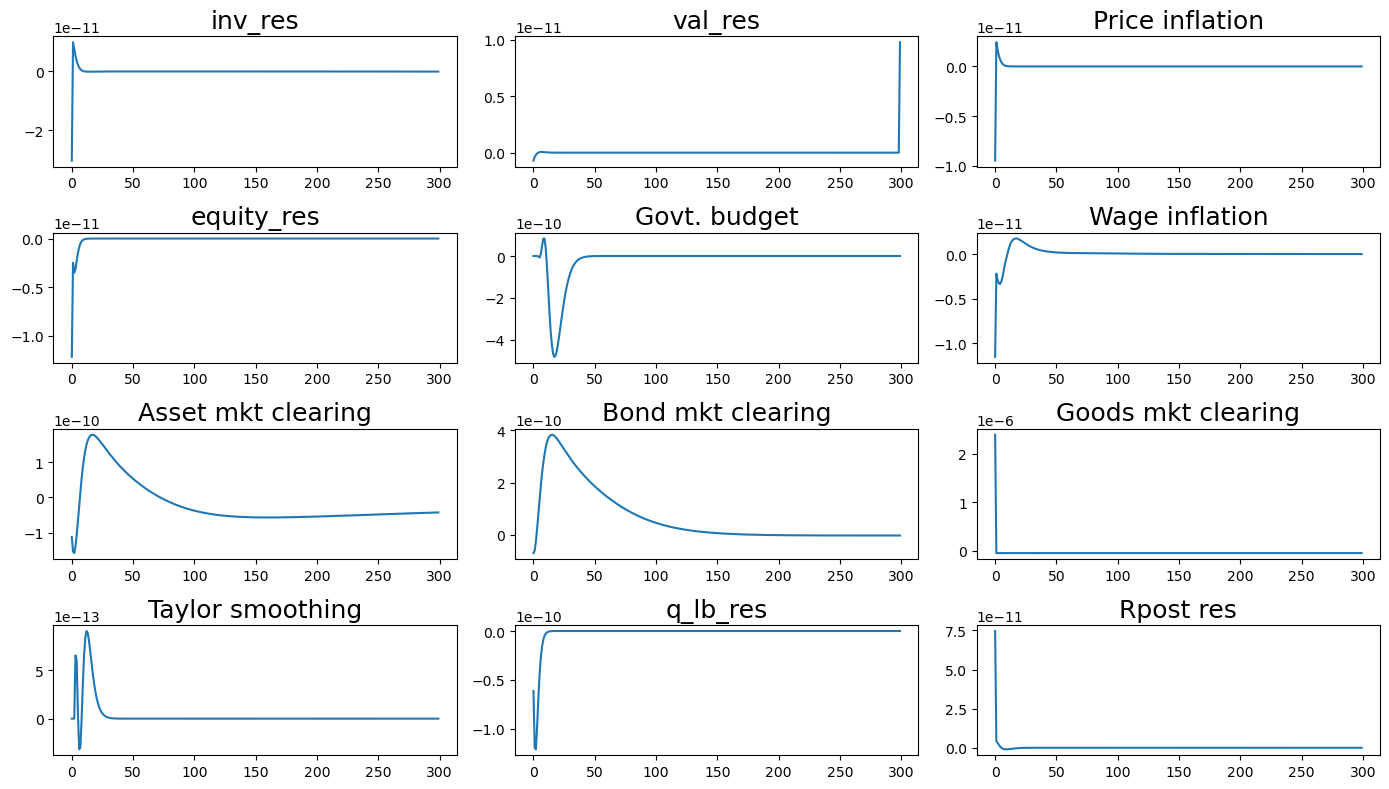

In [5]:
hank_og_residuals = [k for k in hank_og.outputs if is_residual(k)]
plot_residuals(irf_hank_og_r, hank_og_residuals)

In [6]:
irf_hank_og = rebase_irf(ss_hank_end, ss_hank_ini, irf_hank_og_r)

# Save to JSON
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

json.dump(irf_hank_og, open(os.path.join("irfs", "irf_with_OG.json"), 'w'), cls=NumpyEncoder, indent=4)

## Orphanides-Williams rule

In [7]:
print("\n")
print("=" *80)
print(f"The {hank_ow.name} model")
print("=" *80)
print(*hank_ow.blocks, sep='\n')

# Print out inputs and outputs of the HANK model
print(f"The {hank_ow.name} has inputs{hank_ow.inputs}")
print("-" * 80)
print(f"The {hank_ow.name} has outputs {hank_ow.outputs}")



The Two-Asset HANK with an Orphanides-Williams rule model
<SolvedBlock 'labor_to_investment_combined_solved'>
<SolvedBlock 'pricing_solved'>
<SolvedBlock 'orphanides'>
<SolvedBlock 'q_lb'>
<SimpleBlock 'rpost_lb'>
<SimpleBlock 'wage'>
<SimpleBlock 'dividend'>
<SolvedBlock 'G_rule'>
<SimpleBlock 'outcomes'>
<SolvedBlock 'arbitrage_solved'>
<SimpleBlock 'finance'>
<HetBlock 'hh' with hetinput 'make_grids_marginal_cost_grid' and with hetoutput `adjustment_costs'>
<SimpleBlock 'union'>
<SimpleBlock 'mkt_clearing'>
The Two-Asset HANK with an Orphanides-Williams rule has inputs['beta', 'eis', 'rb', 'chi0', 'chi1', 'chi2', 'chi3', 'tax', 'w', 'Transfer', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'Y', 'Z', 'alpha', 'ra_e', 'delta', 'epsI', 'kappap', 'mup', 'pi_ss', 'tau_d', 'Gbar', 'Bgbar', 'phi_G', 'kappaw', 'muw', 'vphi', 'frisch', 'phi', 'pibar', 'rbar', 'delta_lb']
--------------------------------------------------------------------------------
The Two-Asset HAN

In [8]:
additional_parameters = {
    'phi': 0.35,  # Orphanides and Williams (2002, Table 5: Robust Rule)   
}

data = json.load(open(os.path.join("ss", "ss_hank_ini.json")))
data_with_additional = {**data, **additional_parameters}
ss_hank_ini = hank_ow.steady_state(data_with_additional, dissolve=[
    'orphanides',
    'G_rule',
])

print("-" * 80)
print("Initial SS")
print(f"Asset market clearing: {ss_hank_ini['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_ini['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_ini['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_ini.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

data = json.load(open(os.path.join("ss", "ss_hank_end.json")))
data_with_additional = {**data, **additional_parameters}
ss_hank_end = hank_ow.steady_state(data_with_additional, dissolve=[
    'orphanides',
    'G_rule',
])

print("-" * 80)
print("Final SS")
print(f"Asset market clearing: {ss_hank_end['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_end['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_end['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_end.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

--------------------------------------------------------------------------------
Initial SS
Asset market clearing:  2.36e-06
Bond market clearing: -2.24e-08
Goods market clearing (untargeted):  6.48e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
i_res: 0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: -0.000000
equity_res: 0.000000
wnkpc_res: 0.000000
asset_mkt: 0.000002
bond_mkt: -0.000000
goods_mkt: 0.000000
--------------------------------------------------------------------------------
Final SS
Asset market clearing: -5.32e-08
Bond market clearing:  4.97e-08
Goods market clearing (untargeted):  4.52e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: -0.000000
nkpc_res: 0.000000
i_res: 0.000000
q_lb_res: -0.000000
rpost_res: 0.000000
B_res: 0.000000
equity_res: -0.000000
wnkpc_res: -0.00

In [9]:
T = 300

drbar = (ss_hank_end['rbar'] - ss_hank_ini['rbar']) * np.ones(T)
dGbar = (ss_hank_end['Gbar'] - ss_hank_ini['Gbar']) * np.ones(T)
dBgbar = (ss_hank_end['Bgbar'] - ss_hank_ini['Bgbar']) * np.ones(T)

shocks = {'Gbar': dGbar, 'Bgbar': dBgbar, 'rbar': drbar}

shocks_rebased = rebase_irf(ss_hank_ini, ss_hank_end, shocks)
exogenous = shocks_rebased

unknowns = ['Y', 'w', 'ra_e', 'rb']
targets = ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']

hank_ow.solve_impulse_nonlinear_options['maxit'] = 100
hank_ow.solve_impulse_nonlinear_options['tol'] = 1e-9

irf_hank_ow_r =  hank_ow.solve_impulse_nonlinear(ss_hank_end, unknowns, targets, exogenous, ss_initial=ss_hank_ini)

Solving Two-Asset HANK with an Orphanides-Williams rule for ['Y', 'w', 'ra_e', 'rb'] to hit ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 0.00E+00
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 1.34E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 1.03E-08
On iteration 3
   max error for inv_res is 7.13E-09
   max error for val_res is 4.17E-11
On iteration 4
   max error for inv_res is 3.57E-11
   max error for val_res is 2.23E-13
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 1.71E-04
On iteration 1
   max error for nkpc_res is 4.60E-07
On iteration 2
   max error for nkpc_res is 1.95E-09
On iteration 3
   max error for nkpc_res is 7.42E-12
Solving orphanides_inner for ['i'] to hit ['i_res']
On it

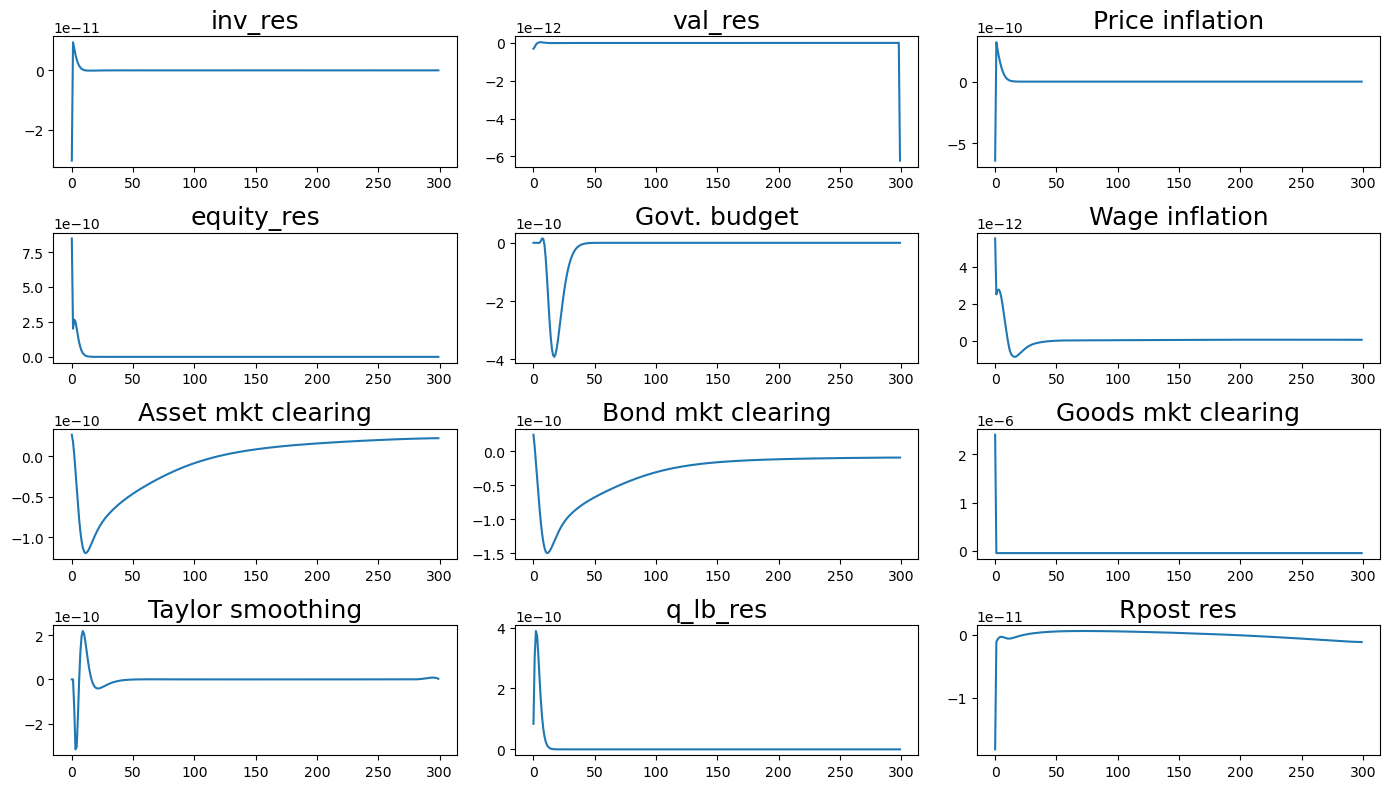

In [10]:
hank_ow_residuals = [k for k in hank_ow.outputs if is_residual(k)]
plot_residuals(irf_hank_ow_r, hank_ow_residuals)

In [11]:
irf_hank_ow = rebase_irf(ss_hank_end, ss_hank_ini, irf_hank_ow_r)

# Save to JSON
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

json.dump(irf_hank_ow, open(os.path.join("irfs", "irf_orphanides.json"), 'w'), cls=NumpyEncoder, indent=4)

## Main monetary figure

In [12]:
irf_baseline = json.load(open(os.path.join("irfs", "irf_baseline.json")))
irf_baseline = {k: np.array(v) for (k, v) in irf_baseline.items()}

irf_orphanides = json.load(open(os.path.join("irfs", "irf_orphanides.json")))
irf_orphanides = {k: np.array(v) for (k, v) in irf_orphanides.items()}

irf_with_OG = json.load(open(os.path.join("irfs", "irf_with_OG.json")))
irf_with_OG = {k: np.array(v) for (k, v) in irf_with_OG.items()}

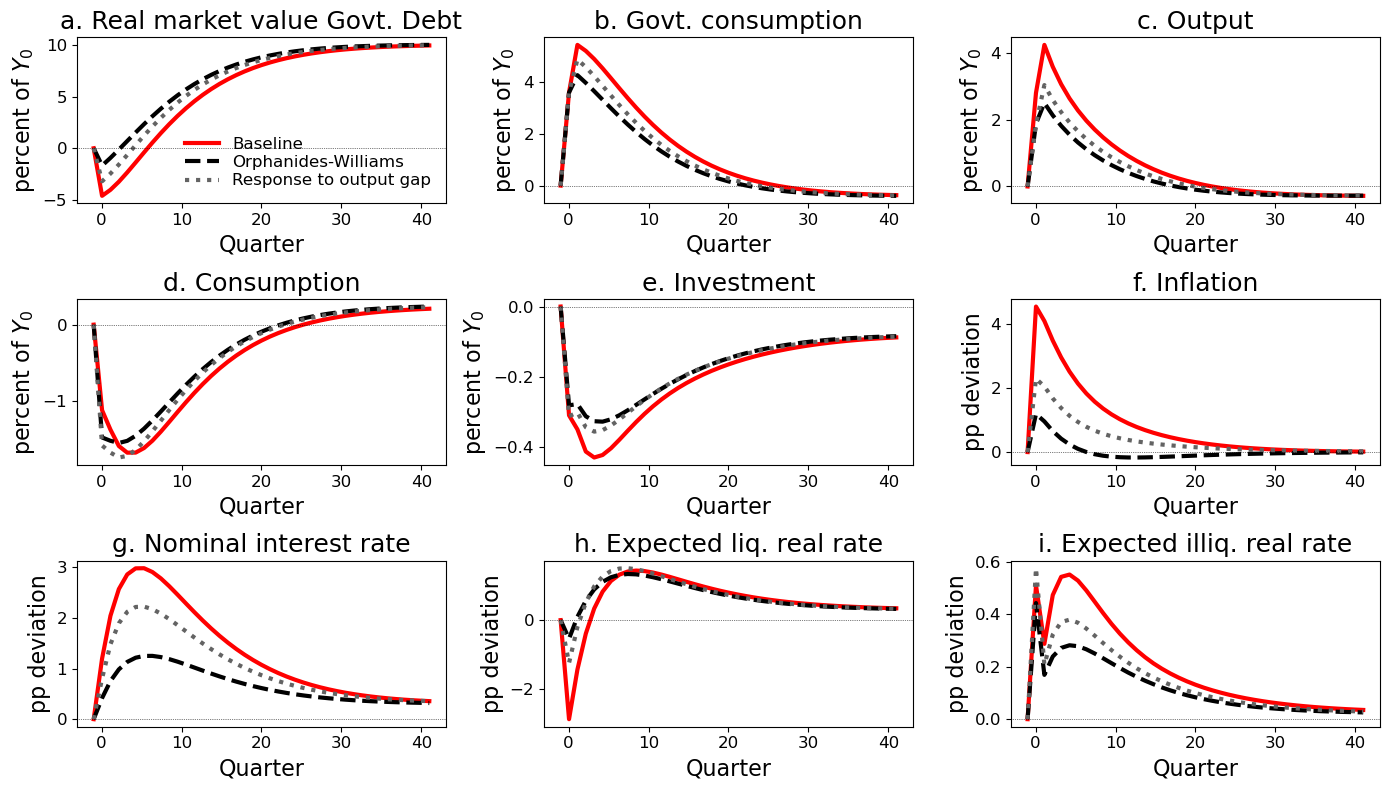

In [13]:
to_plot = {'Baseline': irf_baseline, 'Orphanides-Williams': irf_orphanides, 'Response to output gap': irf_with_OG}
plot_cases = ['Baseline', 'Orphanides-Williams', 'Response to output gap']
save_name = os.path.join("results", "fig_monetary.pdf")
plot_irfs(to_plot, plot_cases, save_name=save_name, variables=['Bg', 'G', 'Y', 'C', 'I', 'pi', 'i', 'rb_e', 'ra_e'], ncols=3, dots=True)

# Appendix

## No smoothing

In [14]:
print("\n")
print("=" *80)
print(f"The {hank_ns.name} model")
print("=" *80)
print(*hank_ns.blocks, sep='\n')

# Print out inputs and outputs of the HANK model
print(f"The {hank_ns.name} has inputs{hank_ns.inputs}")
print("-" * 80)
print(f"The {hank_ns.name} has outputs {hank_ns.outputs}")




The Two-Asset HANK without interest rate smoothing model
<SolvedBlock 'labor_to_investment_combined_solved'>
<SolvedBlock 'pricing_solved'>
<SimpleBlock 'taylor'>
<SolvedBlock 'q_lb'>
<SimpleBlock 'rpost_lb'>
<SimpleBlock 'wage'>
<SimpleBlock 'dividend'>
<SolvedBlock 'G_rule'>
<SimpleBlock 'outcomes'>
<SolvedBlock 'arbitrage_solved'>
<SimpleBlock 'finance'>
<HetBlock 'hh' with hetinput 'make_grids_marginal_cost_grid' and with hetoutput `adjustment_costs'>
<SimpleBlock 'union'>
<SimpleBlock 'mkt_clearing'>
The Two-Asset HANK without interest rate smoothing has inputs['beta', 'eis', 'rb', 'chi0', 'chi1', 'chi2', 'chi3', 'tax', 'w', 'Transfer', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'Y', 'Z', 'alpha', 'ra_e', 'delta', 'epsI', 'kappap', 'mup', 'pi_ss', 'tau_d', 'Gbar', 'Bgbar', 'phi_G', 'kappaw', 'muw', 'vphi', 'frisch', 'rbar', 'phi', 'pibar', 'delta_lb']
--------------------------------------------------------------------------------
The Two-Asset HANK with

In [15]:
data = json.load(open(os.path.join("ss", "ss_hank_ini.json")))
ss_hank_ini = hank_ns.steady_state(data, dissolve=[
    'G_rule',
])

print("-" * 80)
print("Initial SS")
print(f"Asset market clearing: {ss_hank_ini['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_ini['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_ini['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_ini.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

data = json.load(open(os.path.join("ss", "ss_hank_end.json")))
ss_hank_end = hank_ns.steady_state(data, dissolve=[
    'G_rule',
])

print("-" * 80)
print("Final SS")
print(f"Asset market clearing: {ss_hank_end['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_end['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_end['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_end.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")


--------------------------------------------------------------------------------
Initial SS
Asset market clearing:  2.36e-06
Bond market clearing: -2.24e-08
Goods market clearing (untargeted):  6.48e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: -0.000000
equity_res: 0.000000
wnkpc_res: 0.000000
asset_mkt: 0.000002
bond_mkt: -0.000000
goods_mkt: 0.000000
--------------------------------------------------------------------------------
Final SS
Asset market clearing: -5.32e-08
Bond market clearing:  4.97e-08
Goods market clearing (untargeted):  4.52e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: -0.000000
nkpc_res: 0.000000
q_lb_res: 0.000000
rpost_res: -0.000000
B_res: 0.000000
equity_res: -0.000000
wnkpc_res: -0.000000
asset_mkt: -0.000000
bond_m

In [16]:
T = 300

drbar = (ss_hank_end['rbar'] - ss_hank_ini['rbar']) * np.ones(T)
dGbar = (ss_hank_end['Gbar'] - ss_hank_ini['Gbar']) * np.ones(T)
dBgbar = (ss_hank_end['Bgbar'] - ss_hank_ini['Bgbar']) * np.ones(T)

shocks = {'Gbar': dGbar, 'Bgbar': dBgbar, 'rbar': drbar}

shocks_rebased = rebase_irf(ss_hank_ini, ss_hank_end, shocks)
exogenous = shocks_rebased

unknowns = ['Y', 'w', 'ra_e', 'rb']
targets = ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']

hank_ns.solve_impulse_nonlinear_options['maxit'] = 100
hank_ns.solve_impulse_nonlinear_options['tol'] = 1e-9

irf_hank_ns_r =  hank_ns.solve_impulse_nonlinear(ss_hank_end, unknowns, targets, exogenous, ss_initial=ss_hank_ini)

Solving Two-Asset HANK without interest rate smoothing for ['Y', 'w', 'ra_e', 'rb'] to hit ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 0.00E+00
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 1.34E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 1.03E-08
On iteration 3
   max error for inv_res is 7.13E-09
   max error for val_res is 4.17E-11
On iteration 4
   max error for inv_res is 3.57E-11
   max error for val_res is 2.23E-13
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 1.71E-04
On iteration 1
   max error for nkpc_res is 4.60E-07
On iteration 2
   max error for nkpc_res is 1.95E-09
On iteration 3
   max error for nkpc_res is 7.42E-12
Solving q_lb_inner for ['Q_lb'] to hit ['q_lb_res']
On ite

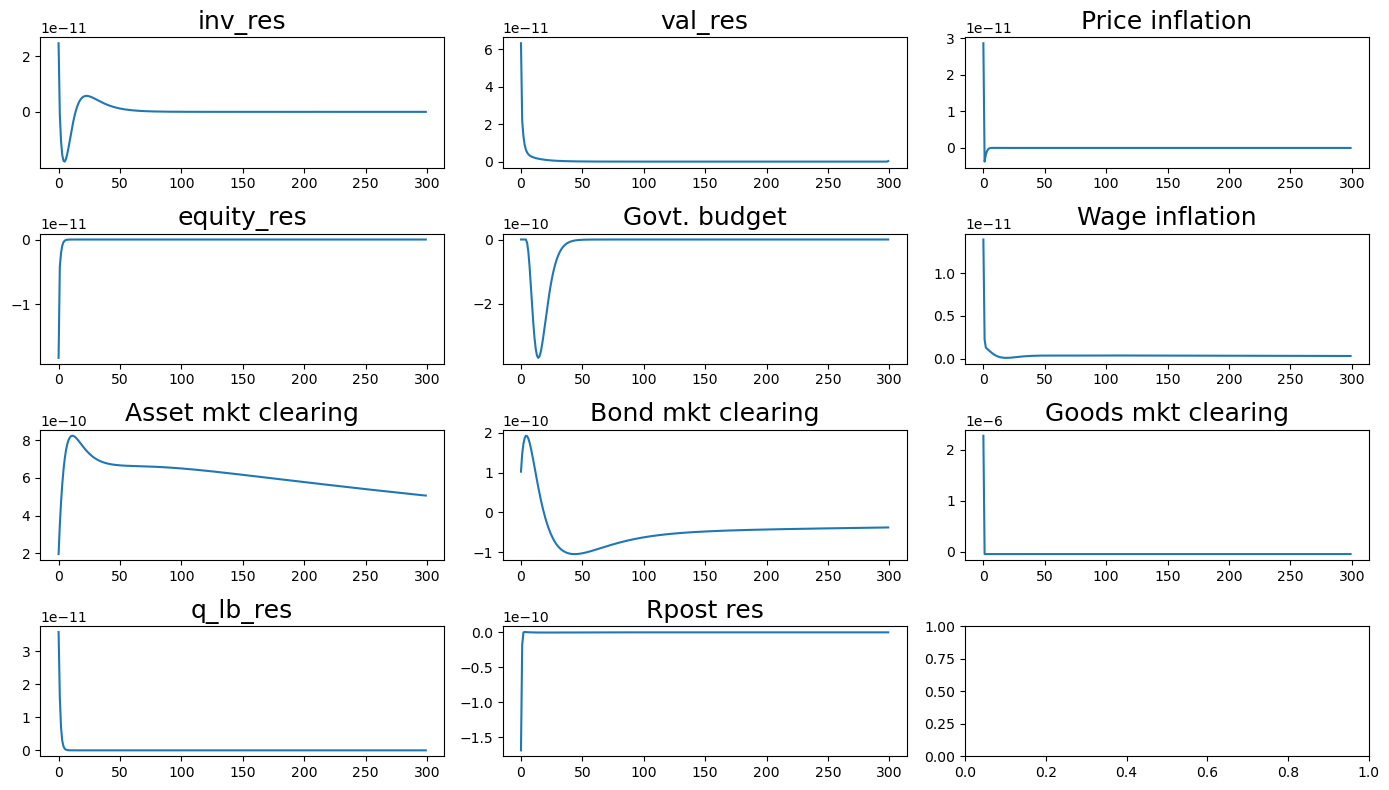

In [17]:
hank_ns_residuals = [k for k in hank_ns.outputs if is_residual(k)]
plot_residuals(irf_hank_ns_r, hank_ns_residuals)

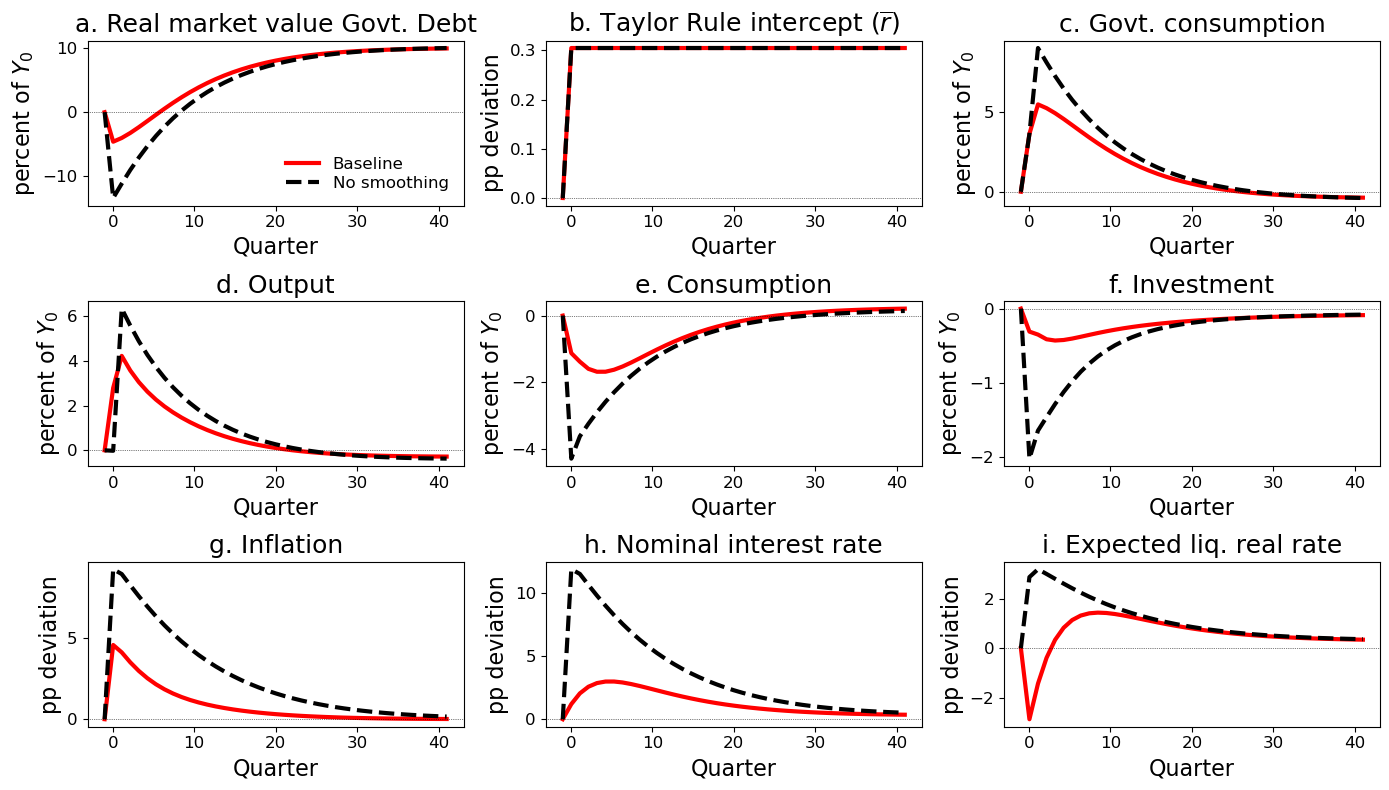

In [18]:
# Figure 15 in the Appendix

irf_hank_ns = rebase_irf(ss_hank_end, ss_hank_ini, irf_hank_ns_r)

irf_baseline = json.load(open(os.path.join("irfs", "irf_baseline.json")))
irf_baseline = {k: np.array(v) for (k, v) in irf_baseline.items()}

to_plot = {'Baseline': irf_baseline, 'No smoothing': irf_hank_ns}
plot_cases = ['Baseline', 'No smoothing']
save_name = os.path.join("results", "HANK_2_no_smoothing.pdf")
plot_irfs(to_plot, plot_cases, save_name=save_name, variables=['Bg', 'rbar', 'G', 'Y', 'C', 'I', 'pi', 'i', 'rb_e'], ncols=3)

In [19]:
# Save to JSON
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

json.dump(irf_hank_ns, open(os.path.join("irfs", "irf_no_smoothing.json"), 'w'), cls=NumpyEncoder, indent=4)

## No reaction

In [20]:
print("\n")
print("=" *80)
print(f"The {hank_lb.name} model")
print("=" *80)
print(*hank_lb.blocks, sep='\n')

# Print out inputs and outputs of the HANK model
print(f"The {hank_lb.name} has inputs{hank_lb.inputs}")
print("-" * 80)
print(f"The {hank_lb.name} has outputs {hank_lb.outputs}")




The Baseline Two-Asset HANK model
<SolvedBlock 'labor_to_investment_combined_solved'>
<SolvedBlock 'pricing_solved'>
<SolvedBlock 'taylor_smooth'>
<SolvedBlock 'q_lb'>
<SimpleBlock 'rpost_lb'>
<SimpleBlock 'wage'>
<SimpleBlock 'dividend'>
<SolvedBlock 'G_rule'>
<SimpleBlock 'outcomes'>
<SolvedBlock 'arbitrage_solved'>
<SimpleBlock 'finance'>
<HetBlock 'hh' with hetinput 'make_grids_marginal_cost_grid' and with hetoutput `adjustment_costs'>
<SimpleBlock 'union'>
<SimpleBlock 'mkt_clearing'>
The Baseline Two-Asset HANK has inputs['beta', 'eis', 'rb', 'chi0', 'chi1', 'chi2', 'chi3', 'tax', 'w', 'Transfer', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'Y', 'Z', 'alpha', 'ra_e', 'delta', 'epsI', 'kappap', 'mup', 'pi_ss', 'tau_d', 'Gbar', 'Bgbar', 'phi_G', 'kappaw', 'muw', 'vphi', 'frisch', 'rbar', 'phi', 'pibar', 'rho_i', 'delta_lb']
--------------------------------------------------------------------------------
The Baseline Two-Asset HANK has outputs ['A', 'B', 'C

In [21]:
data = json.load(open(os.path.join("ss", "ss_hank_ini.json")))
ss_hank_ini = hank_lb.steady_state(data, dissolve=[
    'taylor_smooth',
    'G_rule',
])

print("-" * 80)
print("Initial SS")
print(f"Asset market clearing: {ss_hank_ini['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_ini['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_ini['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_ini.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

data = json.load(open(os.path.join("ss", "ss_hank_end.json")))
ss_hank_end = hank_lb.steady_state(data, dissolve=[
    'taylor_smooth',
    'G_rule',
])

print("-" * 80)
print("Final SS")
print(f"Asset market clearing: {ss_hank_end['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_end['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_end['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_end.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

--------------------------------------------------------------------------------
Initial SS
Asset market clearing:  2.36e-06
Bond market clearing: -2.24e-08
Goods market clearing (untargeted):  6.48e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
i_res: 0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: -0.000000
equity_res: 0.000000
wnkpc_res: 0.000000
asset_mkt: 0.000002
bond_mkt: -0.000000
goods_mkt: 0.000000
--------------------------------------------------------------------------------
Final SS
Asset market clearing: -5.32e-08
Bond market clearing:  4.97e-08
Goods market clearing (untargeted):  4.52e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: -0.000000
nkpc_res: 0.000000
i_res: -0.000000
q_lb_res: -0.000000
rpost_res: 0.000000
B_res: 0.000000
equity_res: -0.000000
wnkpc_res: -0.0

In [22]:
# Linear calculation
delta_pi = (ss_hank_end['rb'] - ss_hank_ini['rbar'])/(ss_hank_ini['phi']-1)
print(f"In a linear approximation, the increase in annual inflation will be equal to {100*((1+delta_pi)**4-1):.2f} pp")
# Non-linear calculation
pi_new = (1+ss_hank_ini['pibar']) * ((1 + ss_hank_end['rb'])/(1 + ss_hank_ini['rbar'])) ** (1/(ss_hank_ini['phi']-1)) - 1
delta_pi_nl = pi_new - ss_hank_ini['pi']
print(f"In the non-linear model, the increase in annual inflation will be equal to {100*((1+delta_pi_nl)**4-1):.2f} pp")

ss_hank_end_candidate = ss_hank_end.copy()
ss_hank_end_candidate['rbar'] = ss_hank_ini['rbar']
ss_hank_end_candidate['pibar'] = ss_hank_ini['pibar']
for v in ['pi', 'pi_ss', 'piw']:
    ss_hank_end_candidate[v] = pi_new # ss_hank_ini[v] + delta_pi
    
ss_hank_end_candidate['i'] = (1+ss_hank_end['rb'])*(1+pi_new) - 1

ss_hank_end_no_reaction = hank_lb.steady_state(ss_hank_end_candidate, dissolve=[
    'taylor_smooth',
    'G_rule',
])

for k, v in ss_hank_end_no_reaction.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

In a linear approximation, the increase in annual inflation will be equal to 1.22 pp
In the non-linear model, the increase in annual inflation will be equal to 1.23 pp
inv_res: 0.000000
val_res: -0.000000
nkpc_res: 0.000000
i_res: -0.000000
q_lb_res: -0.000000
rpost_res: 0.000000
B_res: 0.000000
equity_res: -0.000000
wnkpc_res: -0.000000
asset_mkt: -0.000000
bond_mkt: 0.000000
goods_mkt: 0.000000


In [23]:
T = 300

drbar = (ss_hank_end_no_reaction['rbar'] - ss_hank_ini['rbar']) * np.ones(T)
dGbar = (ss_hank_end_no_reaction['Gbar'] - ss_hank_ini['Gbar']) * np.ones(T)
dBgbar = (ss_hank_end_no_reaction['Bgbar'] - ss_hank_ini['Bgbar']) * np.ones(T)

shocks = {'Gbar': dGbar, 'Bgbar': dBgbar, 'rbar': drbar}

shocks_rebased = rebase_irf(ss_hank_ini, ss_hank_end_no_reaction, shocks)
exogenous = shocks_rebased

unknowns = ['Y', 'w', 'ra_e', 'rb']
targets = ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']

hank_lb.solve_impulse_nonlinear_options['maxit'] = 100
hank_lb.solve_impulse_nonlinear_options['tol'] = 1e-9

irf_hank_nr_r =  hank_lb.solve_impulse_nonlinear(ss_hank_end_no_reaction, unknowns, targets, exogenous, ss_initial=ss_hank_ini)

Solving Baseline Two-Asset HANK for ['Y', 'w', 'ra_e', 'rb'] to hit ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 0.00E+00
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 1.34E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 1.03E-08
On iteration 3
   max error for inv_res is 7.13E-09
   max error for val_res is 4.17E-11
On iteration 4
   max error for inv_res is 3.57E-11
   max error for val_res is 2.23E-13
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 1.71E-04
On iteration 1
   max error for nkpc_res is 4.60E-07
On iteration 2
   max error for nkpc_res is 1.95E-09
On iteration 3
   max error for nkpc_res is 7.42E-12
Solving taylor_smooth_inner for ['i'] to hit ['i_res']
On iteration 0
   max erro

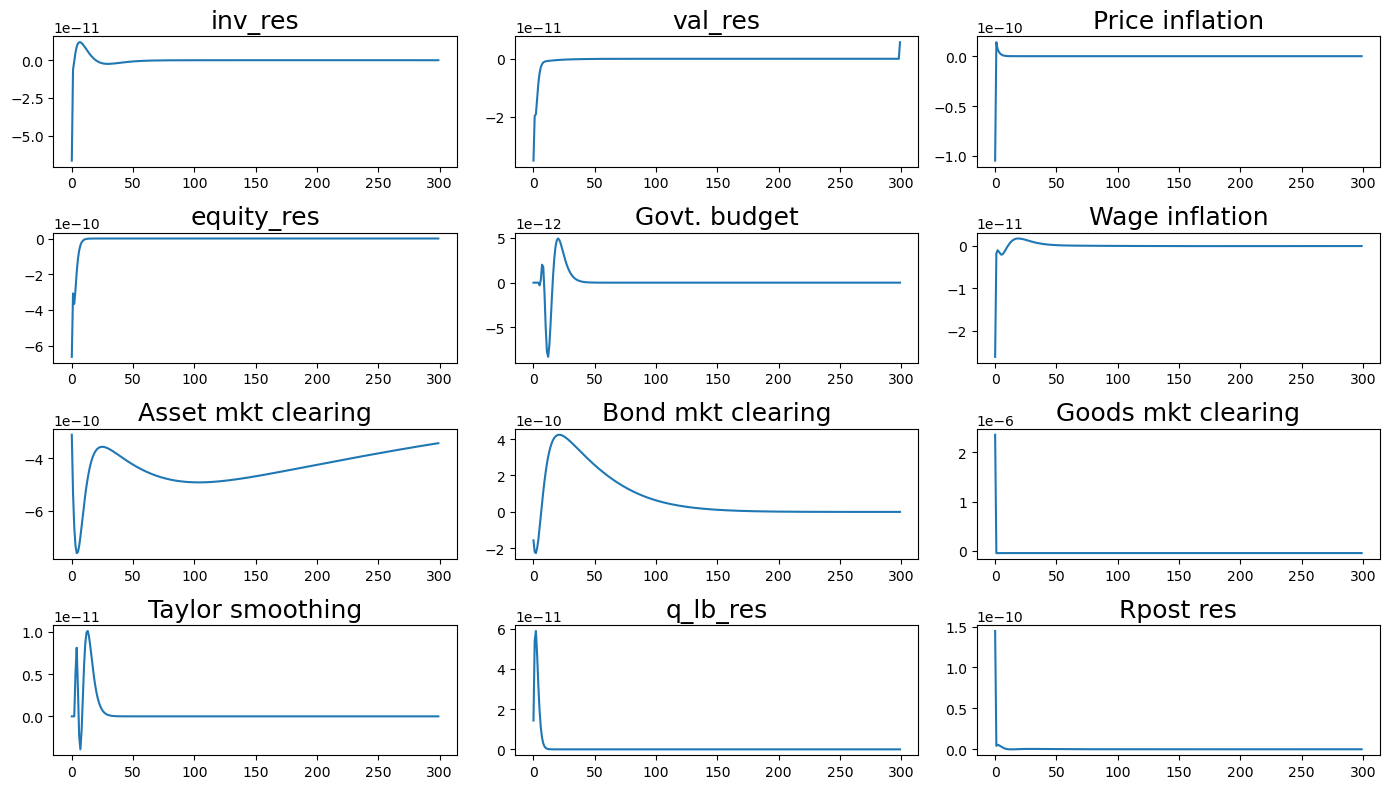

In [24]:
hank_lb_residuals = [k for k in hank_lb.outputs if is_residual(k)]
plot_residuals(irf_hank_nr_r, hank_lb_residuals)

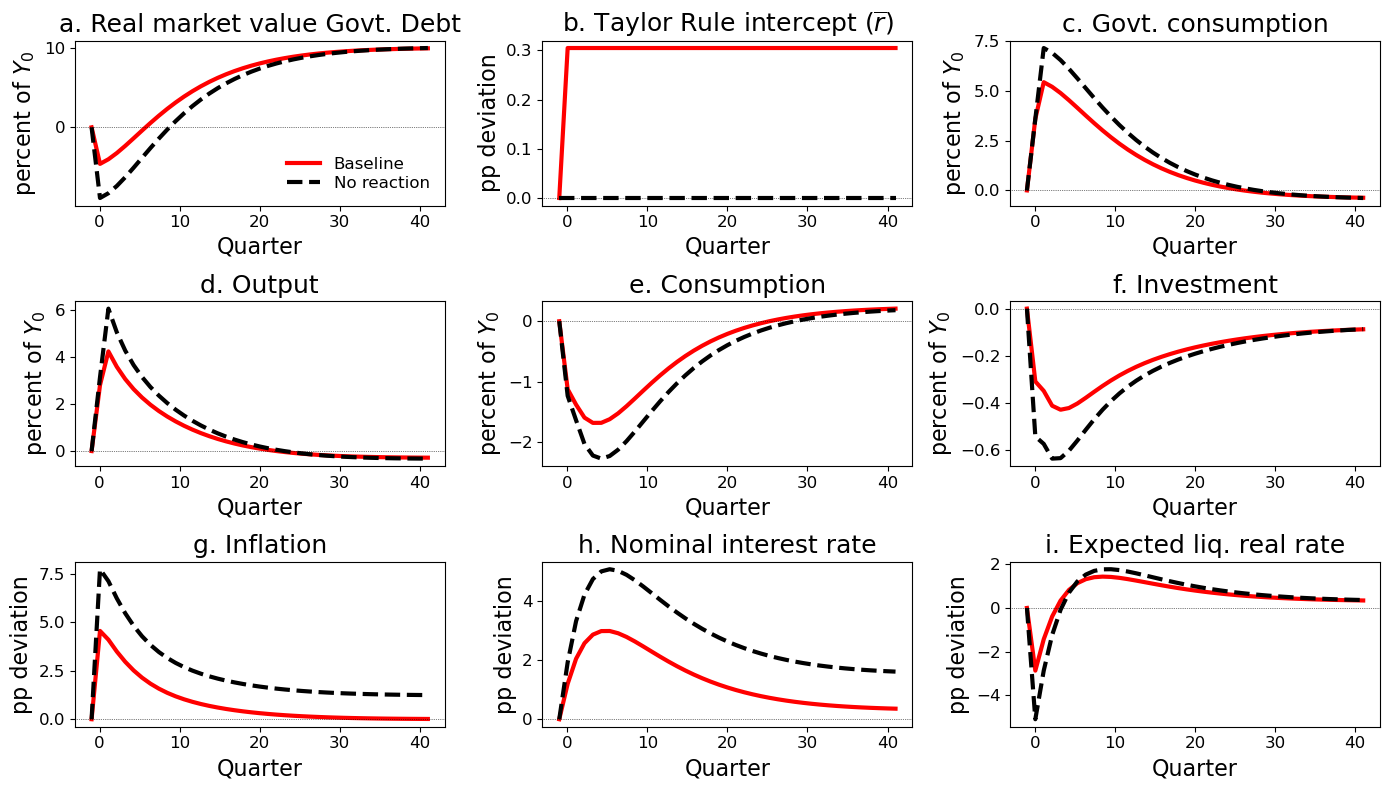

In [25]:
# Figure 14 in the Appendix

irf_hank_nr = rebase_irf(ss_hank_end_no_reaction, ss_hank_ini, irf_hank_nr_r)

irf_baseline = json.load(open(os.path.join("irfs", "irf_baseline.json")))
irf_baseline = {k: np.array(v) for (k, v) in irf_baseline.items()}

to_plot = {'Baseline': irf_baseline, 'No reaction': irf_hank_nr}
plot_cases = ['Baseline', 'No reaction']
save_name = os.path.join("results", "HANK_2_no_reaction.pdf")
plot_irfs(to_plot, plot_cases, save_name=save_name, variables=['Bg', 'rbar', 'G', 'Y', 'C', 'I', 'pi', 'i', 'rb_e'], ncols=3)

In [26]:
# Save to JSON
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

json.dump(irf_hank_nr, open(os.path.join("irfs", "irf_no_reaction.json"), 'w'), cls=NumpyEncoder, indent=4)